In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Load the datasets
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

In [17]:
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotionLabels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

emotion_counts = train_data['emotion'].value_counts()

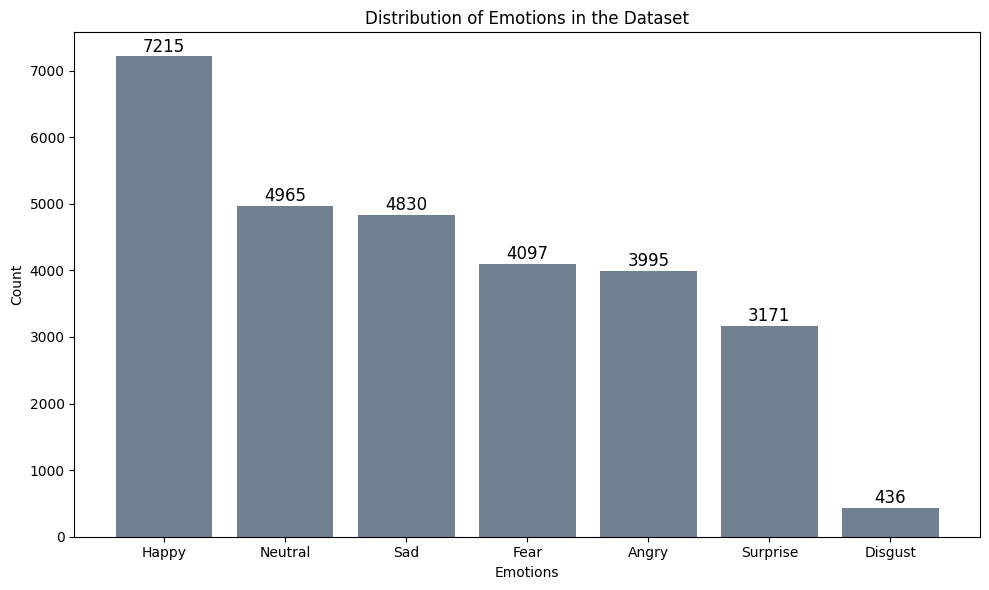

In [18]:
# Count the number of occurrences of each emotion
plt.figure(figsize=(10, 6))

plt.bar([emotionLabels[i] for i in emotion_counts.index], emotion_counts.values, color=['slategray'])

plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Emotions in the Dataset')

for i, count in enumerate(emotion_counts.values):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [19]:
# Function to convert pixel string to image array
def pixels_to_image(pixels_str):
    pixels = np.array(pixels_str.split(), dtype='float32')  
    return pixels.reshape(48, 48)  # Reshape into 48x48 because the images are 48x48 pixels

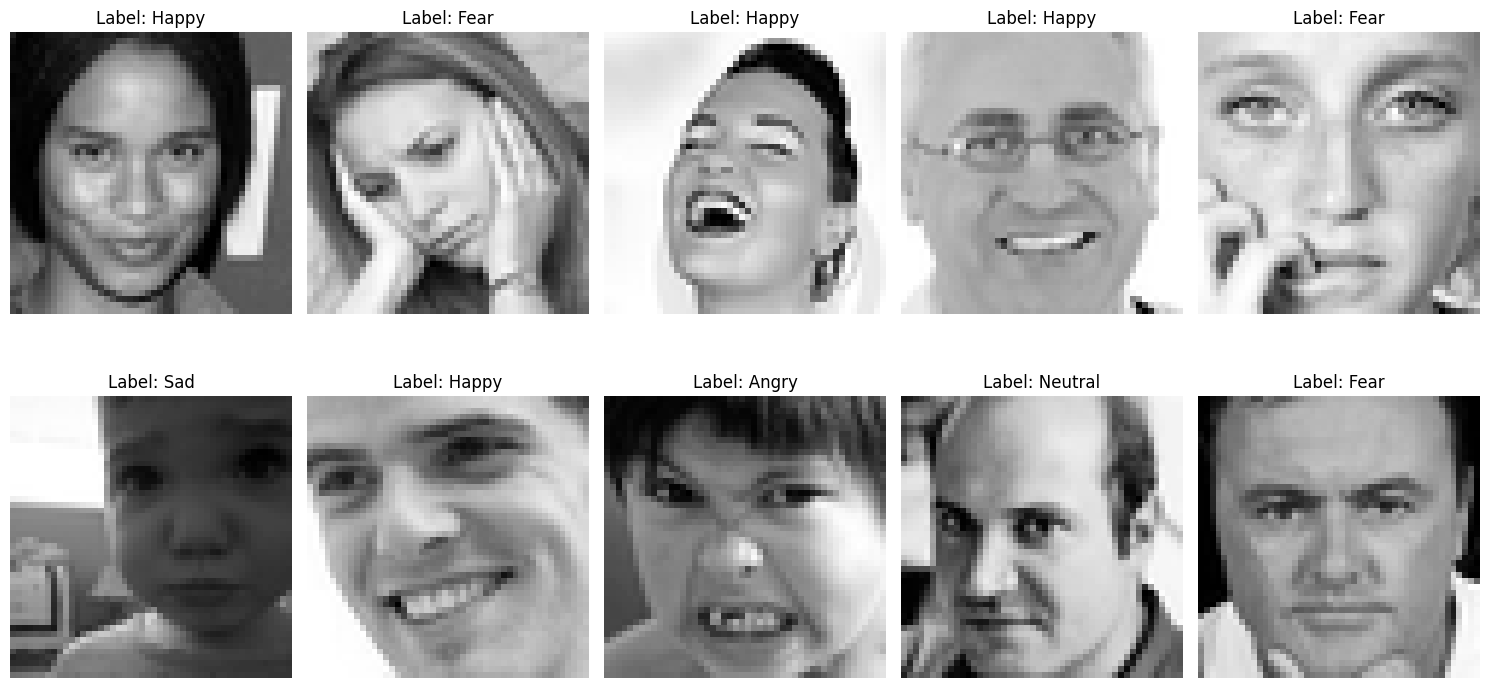

In [20]:
# Display 10 random images
plt.figure(figsize=(15, 8))
for i in range(10):
    idx = np.random.randint(0, len(train_data))

    pixels = train_data.iloc[idx]['pixels']
    label = train_data.iloc[idx]['emotion']  

    # Convert pixels to image
    image = pixels_to_image(pixels)

    # Plot the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {emotionLabels[label]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# BUILDING MODEL

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils import to_categorical

In [22]:
X = train_data['pixels'].apply(lambda x: np.array(x.split()).astype('float32'))
y = train_data['emotion']

# 48x48 pixels
X = np.stack(X.values)
X = X.reshape(-1, 48, 48, 1) 

# Normalize
X = X / 255.0

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=7)

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import Adam

# Nombre de classes (émotions)
nb_classes = 7

# Initialisation du modèle CNN
model = Sequential()

# 1re couche convolutionnelle
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2e couche convolutionnelle
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3e couche convolutionnelle
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4e couche convolutionnelle
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten + couches fully connected
model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Couche de sortie
model.add(Dense(nb_classes, activation='softmax'))

# Compilation avec Adam
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


/opt/anaconda3/envs/ML/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## ANALYSE OPTIMIZER

Dans cette partie, nous analysons le rôle de l’optimiseur Adam dans l’apprentissage de notre CNN. L’étude porte notamment sur :

La fonction de perte utilisée

La nature mathématique du problème d’optimisation

Les hyperparamètres clés de l’algorithme Adam

Les avantages et limites d’Adam dans un contexte non convexe

Une comparaison théorique avec SGD + momentum

### ETAPE 1 : Etudier la fonction de perte

Cette fonction est standard pour la classification multi-classes. Elle mesure la différence entre la distribution prédite (après softmax) et la distribution vraie (one-hot).

In [25]:
from tensorflow.keras.losses import CategoricalCrossentropy

loss_fn = CategoricalCrossentropy()
print("Fonction de perte utilisée :", loss_fn)

Fonction de perte utilisée : <LossFunctionWrapper(<function categorical_crossentropy at 0x331018310>, kwargs={'from_logits': False, 'label_smoothing': 0.0, 'axis': -1})>


* CONVEXITE:

1- La fonction de perte n'est pas convexe car 
La categorical_crossentropy est convexe seule, mais...

Le modèle est un réseau de neurones, ce qui introduit :

* ReLU (non-linéaire)

* Convolution + MaxPooling (non-linéaires ou non différemment linéaires)

* Dense avec activation

Donc l’optimisation devient un problème non convexe, à cause de la composition de fonctions non linéaires.

Par contre, elle est bien différentiable car Oui, partout sauf aux points anguleux des ReLU, mais ces points sont négligeables en pratique.

Ce qu'il faut retenir:
La fonction de perte categorical_crossentropy est utilisée pour la classification multi-classes. Mathématiquement, elle correspond à l'entropie croisée entre deux distributions de probabilité.
Elle est convexe si elle est appliquée à une sortie softmax dans un modèle linéaire, mais le modèle CNN n'étant pas linéaire, la fonction de perte totale devient non convexe. Cela rend l'optimisation plus difficile (possibles minima locaux, plateaux, oscillations...).

In [26]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=128)


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 122s 667ms/step - accuracy: 0.2480 - loss: 1.9913 - val_accuracy: 0.2564 - val_loss: 2.3458
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 118s 655ms/step - accuracy: 0.4046 - loss: 1.5507 - val_accuracy: 0.1771 - val_loss: 2.1498
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 118s 656ms/step - accuracy: 0.4832 - loss: 1.3487 - val_accuracy: 0.3248 - val_loss: 2.0057
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 118s 656ms/step - accuracy: 0.5250 - loss: 1.2356 - val_accuracy: 0.5265 - val_loss: 1.2518
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 116s 642ms/step - accuracy: 0.5618 - loss: 1.1510 - val_accuracy: 0.5012 - val_loss: 1.2601
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 116s 644ms/step - accuracy: 0.5902 - loss: 1.0860 - val_accuracy: 0.5677 - val_loss: 1.1491
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 115s 642ms/step - accuracy: 0.6097 - loss: 1.0372 - val_accuracy: 0.5552 - val_loss: 1.1900
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 116s 642ms/step - accuracy: 0.6297 -

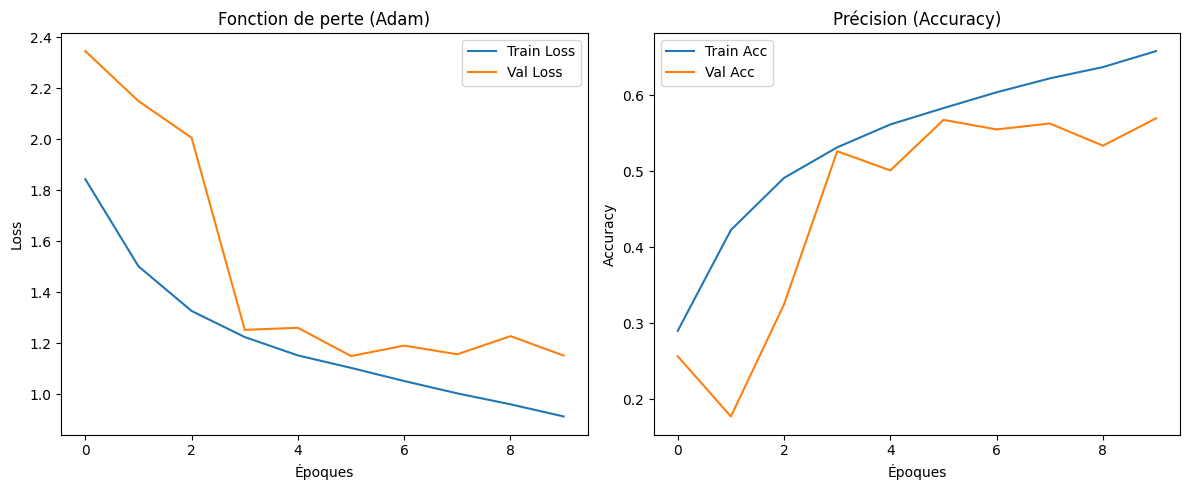

In [27]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Fonction de perte (Adam)")
    plt.xlabel("Époques")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Précision (Accuracy)")
    plt.xlabel("Époques")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

## ETAPE 2 _ Analyser Adam comme algorithme d'optimisation

### Optimiseur Adam — Introduction

L’algorithme **Adam** (Adaptive Moment Estimation) est l’un des plus utilisés pour entraîner des réseaux de neurones profonds, notamment les CNN.

Il combine deux idées :
- Le **momentum** (accélère la descente en accumulant l’historique des gradients)
- L’**adaptation du learning rate** pour chaque poids (comme RMSProp)

C’est une méthode efficace pour les fonctions de perte **non convexes**, ce qui est notre cas ici (CNN + cross-entropy + ReLU).


### Les hyperparamètres clés de Adam à analyser

| Paramètre | Valeur par défaut | Rôle |
|-----------|-------------------|------|
| `learning_rate` | `0.001` | Pas d’apprentissage global |
| `beta_1` | `0.9` | Moyenne des gradients (momentum) |
| `beta_2` | `0.999` | Moyenne des carrés des gradients |
| `epsilon` | `1e-7` | Stabilité numérique |
| `amsgrad` | `False` | Variante améliorée pour convergence théorique |
| `weight_decay` | `None` | Régularisation L2 des poids (évite overfitting) |

Nous allons tester différentes combinaisons pour mesurer l’impact sur la **fonction de perte** et la **vitesse de convergence**.


In [28]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def train_with_adam(lr=0.001, beta1=0.9, beta2=0.999, eps=1e-7, decay=None, amsgrad=False, epochs=15):
    # Cloner le modèle de base
    model_adam = clone_model(model)
    model_adam.set_weights(model.get_weights())

    # Optimiseur Adam avec hyperparamètres personnalisés
    opt = Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2, epsilon=eps,
               weight_decay=decay, amsgrad=amsgrad)

    model_adam.compile(optimizer=opt,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

    history = model_adam.fit(X_train, y_train,
                             validation_data=(X_test, y_test),
                             batch_size=128,
                             epochs=epochs,
                             verbose=0)
    return history


In [29]:
# Valeurs de learning rate à tester
learning_rates = [1e-4, 1e-3, 1e-2]

# Valeurs de beta_1 à tester (momentum du gradient)
beta1_values = [0.8, 0.9, 0.99]

# Valeurs de beta_2 à tester (stabilité du carré du gradient)
beta2_values = [0.9, 0.99, 0.999]

# Valeurs de weight decay (régularisation L2)
weight_decays = [None, 1e-5, 1e-4]


In [30]:
# Stockage des résultats
results_adam = {}

# Test Learning Rate
for lr in learning_rates:
    label = f"LR={lr}"
    results_adam[label] = train_with_adam(lr=lr)

# Test Beta_1
for b1 in beta1_values:
    label = f"Beta1={b1}"
    results_adam[label] = train_with_adam(beta1=b1)

# Test Beta_2
for b2 in beta2_values:
    label = f"Beta2={b2}"
    results_adam[label] = train_with_adam(beta2=b2)

# Test Weight Decay
for wd in weight_decays:
    label = f"WeightDecay={wd if wd else 'None'}"
    results_adam[label] = train_with_adam(decay=wd)


In [42]:
for label, history in results_adam.items():
    val_loss = history.history['val_loss'][-1]  
    print(f"{label} -> val_loss: {val_loss}")


LR=0.0001 -> val_loss: 1.1495031118392944
LR=0.001 -> val_loss: 1.6000888347625732
LR=0.01 -> val_loss: 1.9269870519638062
Beta1=0.8 -> val_loss: 1.7098866701126099
Beta1=0.9 -> val_loss: 1.757851243019104
Beta1=0.99 -> val_loss: 1.5384868383407593
Beta2=0.9 -> val_loss: 1.7071894407272339
Beta2=0.99 -> val_loss: 1.806233525276184
Beta2=0.999 -> val_loss: 1.5085304975509644
WeightDecay=None -> val_loss: 1.5689926147460938
WeightDecay=1e-05 -> val_loss: 1.577324628829956
WeightDecay=0.0001 -> val_loss: 1.59742271900177


In [43]:
for label, history in results_adam.items():
    val_accuracy = history.history['val_accuracy'][-1]  
    print(f"{label} -> val_accuracy: {val_accuracy}")

LR=0.0001 -> val_accuracy: 0.6264367699623108
LR=0.001 -> val_accuracy: 0.5595611333847046
LR=0.01 -> val_accuracy: 0.4446186125278473
Beta1=0.8 -> val_accuracy: 0.5827237963676453
Beta1=0.9 -> val_accuracy: 0.5564263463020325
Beta1=0.99 -> val_accuracy: 0.5902124643325806
Beta2=0.9 -> val_accuracy: 0.5323929190635681
Beta2=0.99 -> val_accuracy: 0.5555555820465088
Beta2=0.999 -> val_accuracy: 0.5888192057609558
WeightDecay=None -> val_accuracy: 0.5609543919563293
WeightDecay=1e-05 -> val_accuracy: 0.5780215859413147
WeightDecay=0.0001 -> val_accuracy: 0.5586903691291809


In [47]:
# Crée des dictionnaires pour chaque hyperparamètre
groups = {
    "Learning Rate": {},
    "Beta1": {},
    "Beta2": {},
    "Weight Decay": {}
}

# Répartir les courbes selon leur label
for name, hist in results_adam.items():
    if "LR=" in name:
        groups["Learning Rate"][name] = hist
    elif "Beta1=" in name:
        groups["Beta1"][name] = hist
    elif "Beta2=" in name:
        groups["Beta2"][name] = hist
    elif "WeightDecay=" in name:
        groups["Weight Decay"][name] = hist

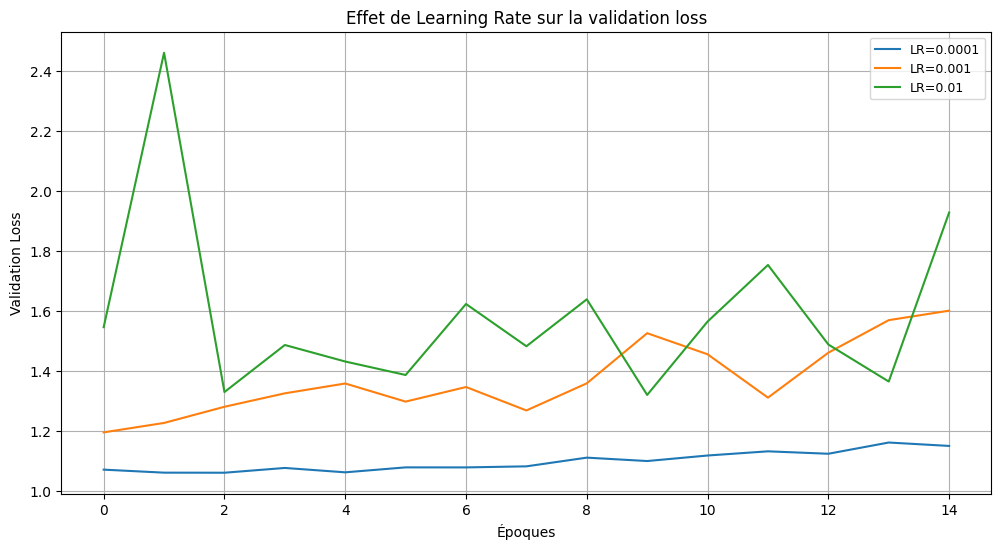

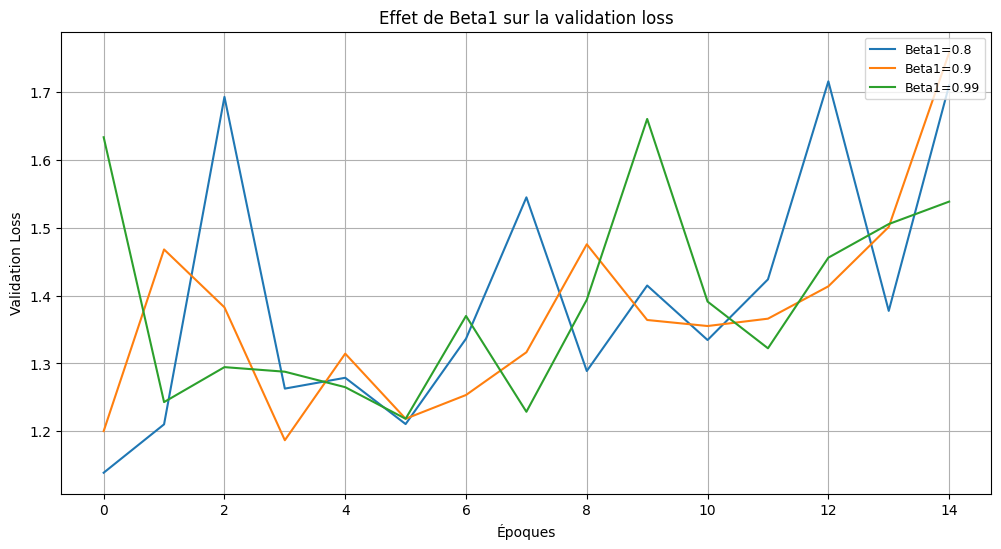

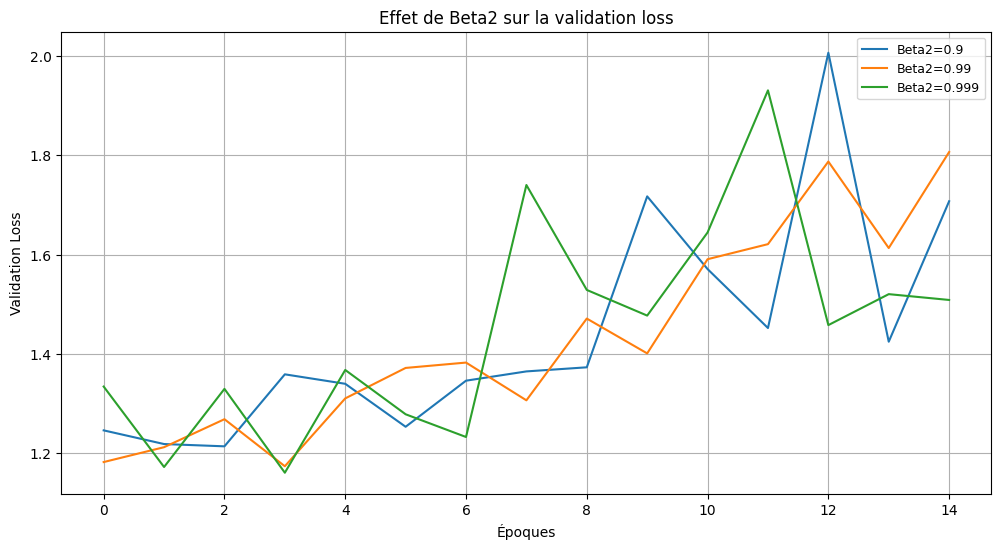

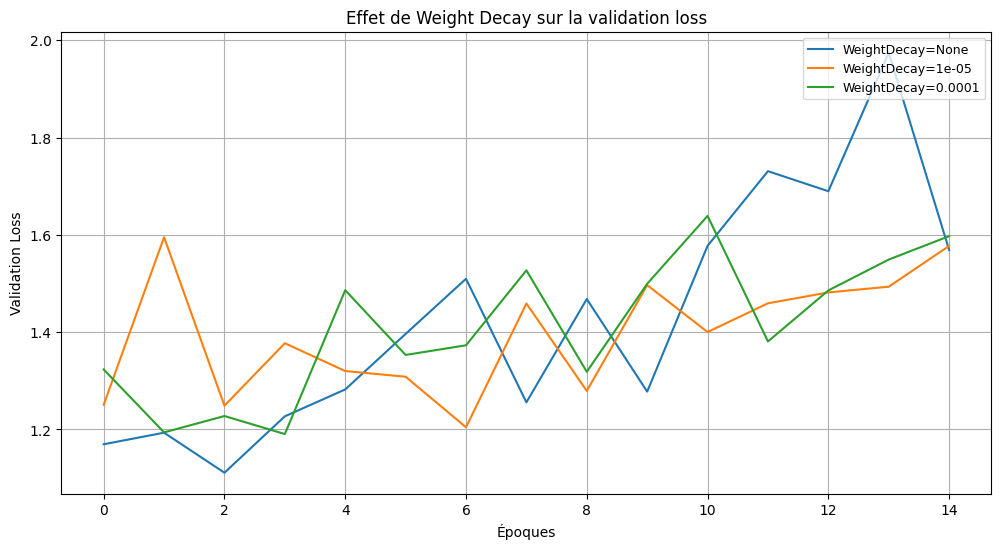

In [48]:
# Plot pour chaque groupe
for group_name, group_histories in groups.items():
    plt.figure(figsize=(12, 6))
    for name, hist in group_histories.items():
        plt.plot(hist.history['val_loss'], label=name)

    plt.title(f"Effet de {group_name} sur la validation loss")
    plt.xlabel("Époques")
    plt.ylabel("Validation Loss")
    plt.legend(loc="upper right", fontsize=9)
    plt.grid(True)
    plt.show()

### Résumé des impacts observés :

- 📉 `learning_rate` trop faible : convergence très lente, parfois pas de réelle descente.
- 📈 `learning_rate` trop grand : descente rapide mais parfois instable (rebonds).
- 🔁 `beta_1` élevé → très stable mais lent ; faible → plus réactif, mais plus bruité.
- 🔂 `beta_2` élevé → utile quand les gradients sont très variables (ex : début d'entraînement).
- 🧱 `weight_decay` : stabilise la loss après plusieurs époques, réduit overfitting.



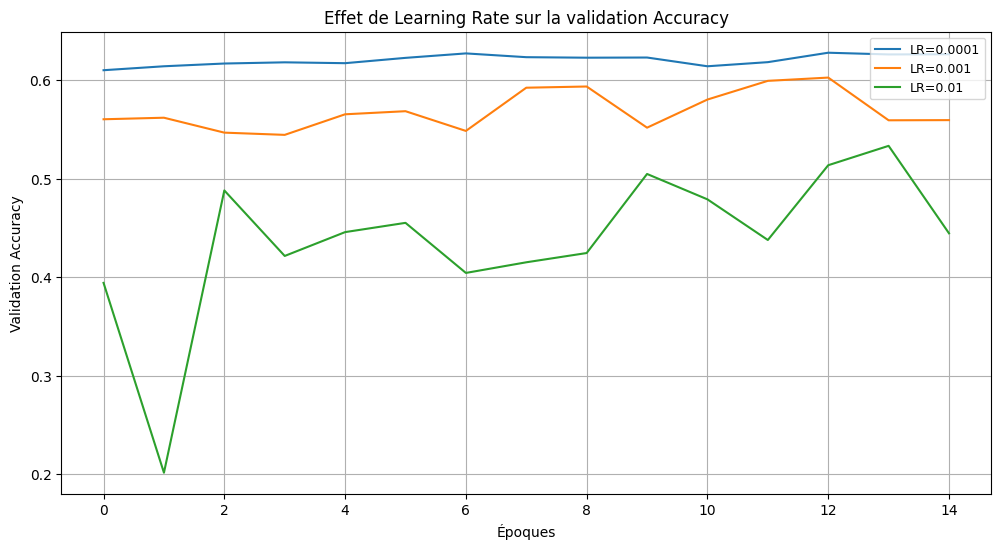

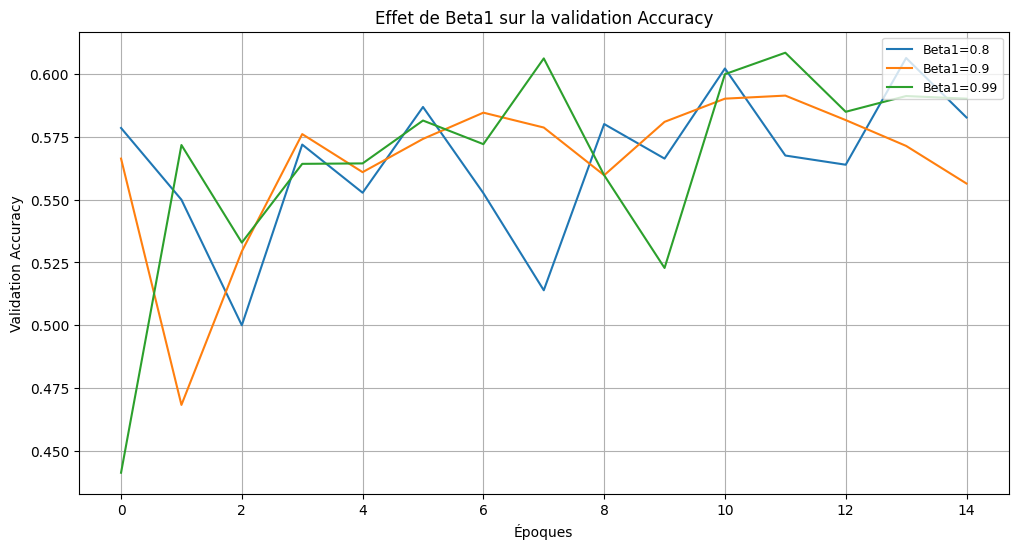

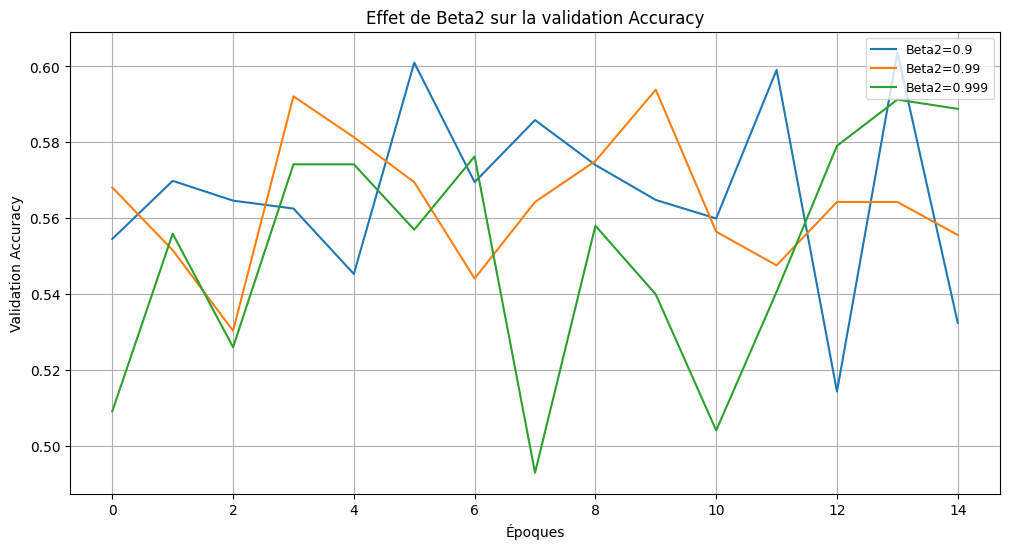

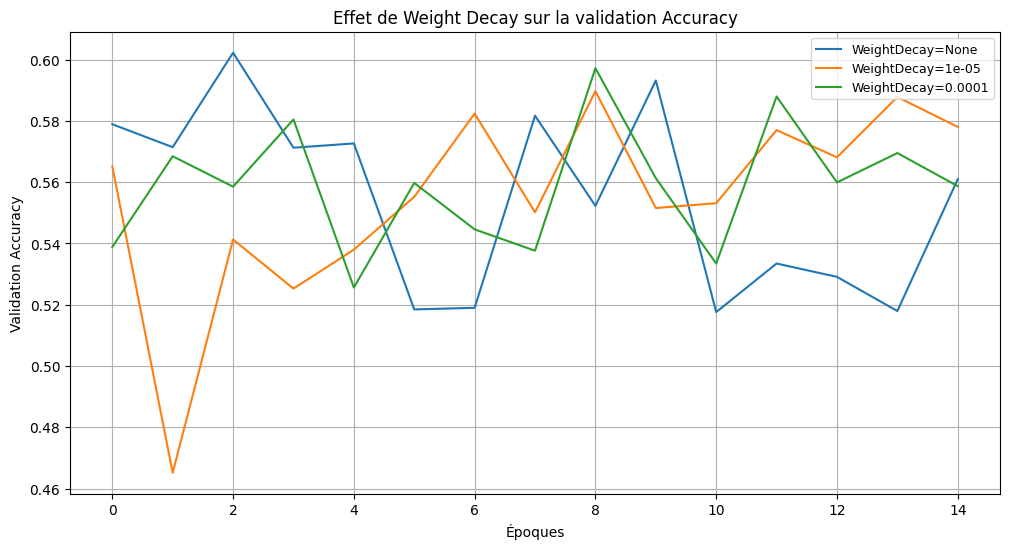

In [49]:
for group_name, group_histories in groups.items():
    plt.figure(figsize=(12, 6))
    for name, hist in group_histories.items():
        plt.plot(hist.history['val_accuracy'], label=name)

    plt.title(f"Effet de {group_name} sur la validation Accuracy")
    plt.xlabel("Époques")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc="upper right", fontsize=9)
    plt.grid(True)
    plt.show()

### 🧠 Analyse de l'accuracy :

- Les courbes permettent de repérer :
    - 📈 Une montée rapide = bonne **vitesse de convergence**
    - 🔁 Une stabilisation haute = bon **plateau de performance**
    - 📉 Une chute soudaine après montée = signe de **sur-apprentissage**

Compare les pics de validation accuracy et observe :
- Quel `learning_rate` donne la meilleure montée ?
- Quel `beta1` stabilise le mieux ?
- L’impact du `weight_decay` sur la stabilité en fin d’apprentissage.


In [51]:
# Analyser la vitesse de convergence 
#On affiche ici l’époque à laquelle la validation accuracy dépasse un seuil 
def get_convergence_epoch(history, threshold):
    acc = history.history['val_accuracy']
    for i, a in enumerate(acc):
        if a >= threshold:
            return i + 1
    return None

threshold = 0.60

for name, hist in results_adam.items():
    epoch = get_convergence_epoch(hist, threshold)
    if epoch:
        print(f"{name} atteint {threshold*100:.0f}% val_acc à l’époque {epoch}")
    else:
        print(f"{name} n’atteint pas {threshold*100:.0f}% val_acc")


LR=0.0001 atteint 60% val_acc à l’époque 1
LR=0.001 atteint 60% val_acc à l’époque 13
LR=0.01 n’atteint pas 60% val_acc
Beta1=0.8 atteint 60% val_acc à l’époque 11
Beta1=0.9 n’atteint pas 60% val_acc
Beta1=0.99 atteint 60% val_acc à l’époque 8
Beta2=0.9 atteint 60% val_acc à l’époque 6
Beta2=0.99 n’atteint pas 60% val_acc
Beta2=0.999 n’atteint pas 60% val_acc
WeightDecay=None atteint 60% val_acc à l’époque 3
WeightDecay=1e-05 n’atteint pas 60% val_acc
WeightDecay=0.0001 n’atteint pas 60% val_acc


## Compiler le modèle avec les meilleurs hyperparamètres choisis

In [52]:
best_lr = 0.0001
best_beta1 = 0.99
best_beta2 = 0.999
best_decay = 1e-5

In [53]:
model.compile(optimizer=Adam(learning_rate=best_lr,beta_1=best_beta1, beta_2=best_beta2, epsilon=1e-7,
               weight_decay=best_decay, amsgrad=False),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [55]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [56]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping])

model.save('goatv1.keras')

# Eval
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7095 - loss: 0.7917 - val_accuracy: 0.6109 - val_loss: 1.0587
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.7230 - loss: 0.7400 - val_accuracy: 0.6101 - val_loss: 1.0657
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7348 - loss: 0.7120 - val_accuracy: 0.6177 - val_loss: 1.0608
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7406 - loss: 0.6962 - val_accuracy: 0.6191 - val_loss: 1.0639
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7515 - loss: 0.6720 - val_accuracy: 0.6184 - val_loss: 1.0704
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7562 - loss: 0.6537 - val_accuracy: 0.6254 - val_loss: 1.0734
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.7707 - loss: 0.6289 - val_accuracy: 0.6245 - val_loss: 1.0909
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7662 - loss: 0.6271 - val_accuracy: 0.

In [57]:
def plot_model_history_only(history):

  metrics = [key for key in history.history if not key.startswith('val_')]

  for metric_name in metrics:
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(history.history[metric_name]) + 1)
    plt.plot(epochs, history.history[metric_name], 'b-', label=f'Training {metric_name}')

    val_metric_name = f'val_{metric_name}'
    if val_metric_name in history.history:
      plt.plot(epochs, history.history[val_metric_name], 'r-', label=f'Validation {metric_name}')
      plt.legend()

    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.grid(True)
    plt.show()


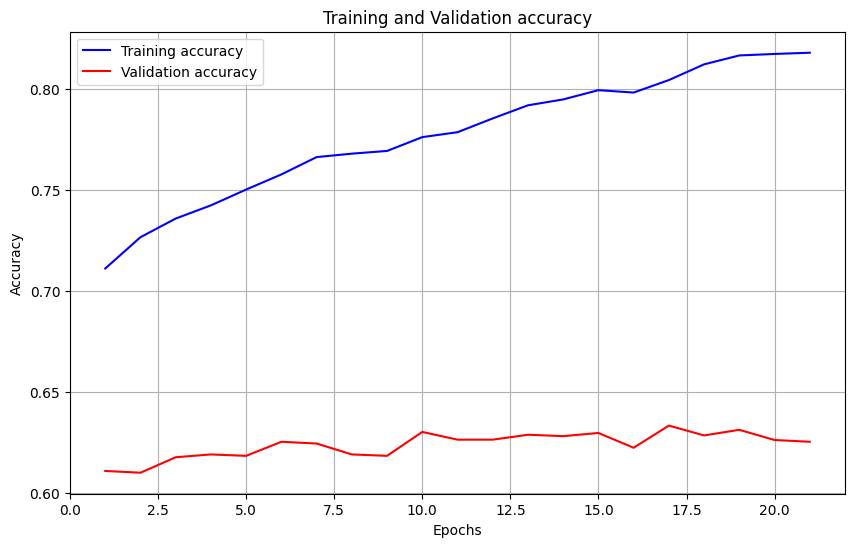

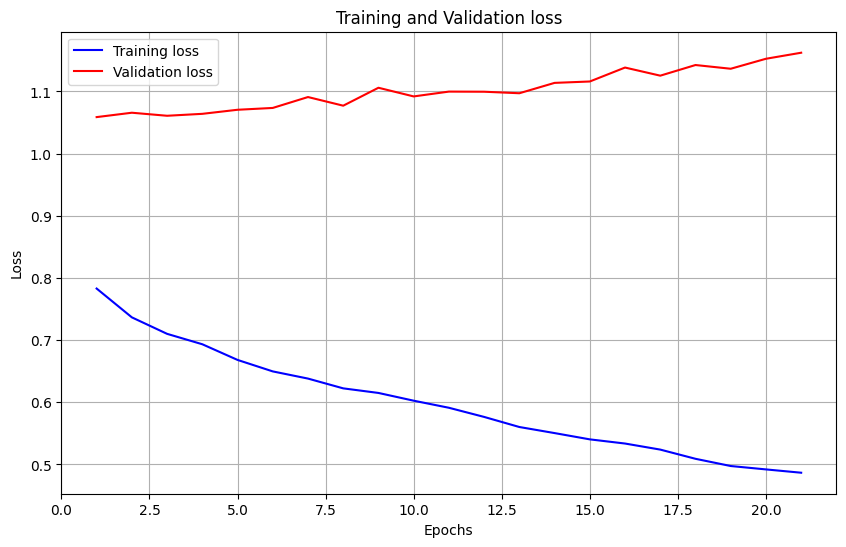

In [58]:
plot_model_history_only(history)